In [6]:
# !pip install pickle5  # pickle is part of the standard library, but pickle5 can be used for enhanced features
# !pip install numpy
# !pip install requests
# !pip install pandas
# !pip install glob2  # glob is part of the standard library, but glob2 is an enhanced version
# !pip install scipy
# !pip install matplotlib
# !pip install seaborn
# !pip install tabulate

import pickle
import numpy as np
from multiprocessing import Pool

import requests, json
import pandas as pd
import glob
import time
from multiprocessing import Pool
import numpy as np
from scipy import stats

def toc(start_time):
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
    
# from zipfile import ZipFile
import re
# from pprint import pprint
# import glob
import pickle

import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as mtransforms
sns.set_theme(style='white')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
sns.set_context('talk', font_scale=.65)
mpl.rcParams.update({'text.usetex': False})

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pandas as pd
# # Choose an embedding backend
# !pip install bertopic[flair, gensim, spacy, use]

# # Topic modeling with images
# !pip install bertopic[vision]
# !pip install xgi==0.7.3
# !pip install distinctipy
# Load document info and topic frequencies


## climate subreddit only

In [7]:
# Load document info and topic frequencies
df_topics_all = pd.read_pickle("./data/df_topics_annotation_paper1_0.pkl")
freq_all = pd.read_pickle("./data/freq_annotation_paper1_0.pkl")
df_joint_w_topics = pd.read_pickle("./data/df_joint_w_topics_annotation_paper1_0.pkl")

# Drop duplicate documents
df_topics_all = df_topics_all.drop_duplicates(subset=['Document'])

df_nuclear = df_topics_all[df_topics_all.Name=='1_nuclear_reactors_reactor_uranium']
comments = list(df_nuclear['Document'])
df_joint_nuclear = df_joint_w_topics[df_joint_w_topics.Topic_name=='1_nuclear_reactors_reactor_uranium']


In [8]:
freq_all

,Topic,Count,Name,Representation,Representative_Docs
0,-1,834656,-1_co2_warming_temperature_science,"[co2, warming, temperature, science, we, our, ...",[Not really a fan of the attitude that we don'...
1,0,9400,0_fires_wildfires_fire_wildfire,"[fires, wildfires, fire, wildfire, arson, bush...",[Summer of Fire: Climate Change Driving Wildfi...
2,1,9290,1_nuclear_reactors_reactor_uranium,"[nuclear, reactors, reactor, uranium, chernoby...","[Nuclear is good, And nuclear as well, Nuclear..."
3,2,7143,2_antarctic_antarctica_arctic_extent,"[antarctic, antarctica, arctic, extent, ice, i...","[Antarctica's melting ice, Arctic sea ice -- c..."
4,3,4921,3_she_shes_her_girl,"[she, shes, her, girl, herself, parents, child...","[Why is she even there?, No, why would she?, S..."
...,...,...,...,...,...
9992,9991,10,9991_cmaoncrying_maralargo_ayyyy_wins,"[cmaoncrying, maralargo, ayyyy, wins, toad, gf...","[Good. I hope he wins., Ayyyy CMAO\n(Crying my..."
9993,9992,10,9992_hustling_worried_despondent_concerned,"[hustling, worried, despondent, concerned, suv...","[It’s about time they get worried., Who is wor..."
9994,9993,10,9993_ooops_specie_proposition_cleared,"[ooops, specie, proposition, cleared, ludicrou...",[Did someone think it had? What a ludicrous pr...
9995,9994,10,9994_dogbert_greentech_printers_healthiest,"[dogbert, greentech, printers, healthiest, sof...",[not sure if this is the healthiest approach b...


In [39]:
# Import sentence transformers and other needed packages
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import os
def setup_local_model(model_name='all-MiniLM-L6-v2'):
    """Download and setup the model locally"""
    # Define local cache directory 
    cache_dir = os.path.join(os.getcwd(), 'models')
    os.makedirs(cache_dir, exist_ok=True)
    
    try:
        # First, download the model files locally if they don't exist
        local_model_path = os.path.join(cache_dir, model_name)
        if not os.path.exists(local_model_path):
            print(f"Downloading model {model_name} to {local_model_path}...")
            snapshot_download(
                repo_id=f"sentence-transformers/{model_name}",
                local_dir=local_model_path,
                local_dir_use_symlinks=False
            )
        
        # Load the model from local cache
        model = SentenceTransformer(local_model_path)
        return model
    
    except Exception as e:
        print(f"Error setting up local model: {e}")
        return None

# Setup and load SBERT model locally
model = setup_local_model('all-MiniLM-L6-v2')
if model is None:
    print("Error loading model, exiting...")
    exit()

# Remove topic -1 and filter for topics with >50 posts
freq_filtered = freq_all[freq_all.Topic != -1]
freq_filtered = freq_filtered[freq_filtered.Count > 50]
topic_names = freq_filtered['Name'].apply(lambda x: ' '.join(x.split('_')[1:]) + ' climate')
topic_texts = [f"{name}" for name in topic_names]
combined_texts = topic_texts

# Get embeddings with progress bar
print("Generating embeddings...")
embeddings = model.encode(combined_texts, show_progress_bar=True)

# Calculate similarity matrix
sim_matrix = cosine_similarity(embeddings)

# Set threshold for merging
SIMILARITY_THRESHOLD = 0.7

# Track merged topics
merged = set()
merged_groups = []

# Find similar topics to merge with progress bar
print("Finding similar topics...")
for i in tqdm(range(len(topic_texts)), desc="Processing topics"):
    if i in merged:
        continue
        
    group = [i]
    for j in range(i+1, len(topic_texts)):
        if j in merged:
            continue
        if sim_matrix[i,j] > SIMILARITY_THRESHOLD:
            group.append(j)
            merged.add(j)
    
    if len(group) > 1:
        merged_groups.append(group)
        
# Create mapping of merged topics
topic_mapping = {}
for group in merged_groups:
    main_topic = group[0]
    for topic in group[1:]:
        topic_mapping[topic] = main_topic

# Create new dataframe with merged topics
freq_merged = freq_filtered.copy()
freq_merged['Name'] = freq_merged['Name'].apply(lambda x: ' '.join(x.split('_')[1:]) + ' climate')

# Map merged topics to main topic with progress bar
print("Mapping merged topics...")
for old_idx, new_idx in tqdm(topic_mapping.items(), desc="Mapping topics"):
    freq_merged.iloc[old_idx, freq_merged.columns.get_loc('Name')] = freq_merged.iloc[new_idx, freq_merged.columns.get_loc('Name')]

print(f"Merged {len(topic_mapping)} similar topics into {len(merged_groups)} groups")
freq_merged.head()


Generating embeddings...


Batches: 100%|██████████| 77/77 [00:03<00:00, 20.99it/s]


Finding similar topics...


Processing topics: 100%|██████████| 2463/2463 [00:00<00:00, 6729.02it/s]


Mapping merged topics...


Mapping topics: 100%|██████████| 558/558 [00:00<00:00, 14675.51it/s]

Merged 558 similar topics into 330 groups


,Topic,Count,Name,Representation,Representative_Docs
1,0,9400,fires wildfires fire wildfire climate,"[fires, wildfires, fire, wildfire, arson, bush...",[Summer of Fire: Climate Change Driving Wildfi...
2,1,9290,nuclear reactors reactor uranium climate,"[nuclear, reactors, reactor, uranium, chernoby...","[Nuclear is good, And nuclear as well, Nuclear..."
3,2,7143,antarctic antarctica arctic extent climate,"[antarctic, antarctica, arctic, extent, ice, i...","[Antarctica's melting ice, Arctic sea ice -- c..."
4,3,4921,she shes her girl climate,"[she, shes, her, girl, herself, parents, child...","[Why is she even there?, No, why would she?, S..."
5,4,4499,tide gauges gauge sea climate,"[tide, gauges, gauge, sea, acceleration, level...","[The sea level rise., &gt; the data from thous..."


C:\Users\chowdhary\AppData\Local\Temp\ipykernel_38900\3385937247.py:81: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



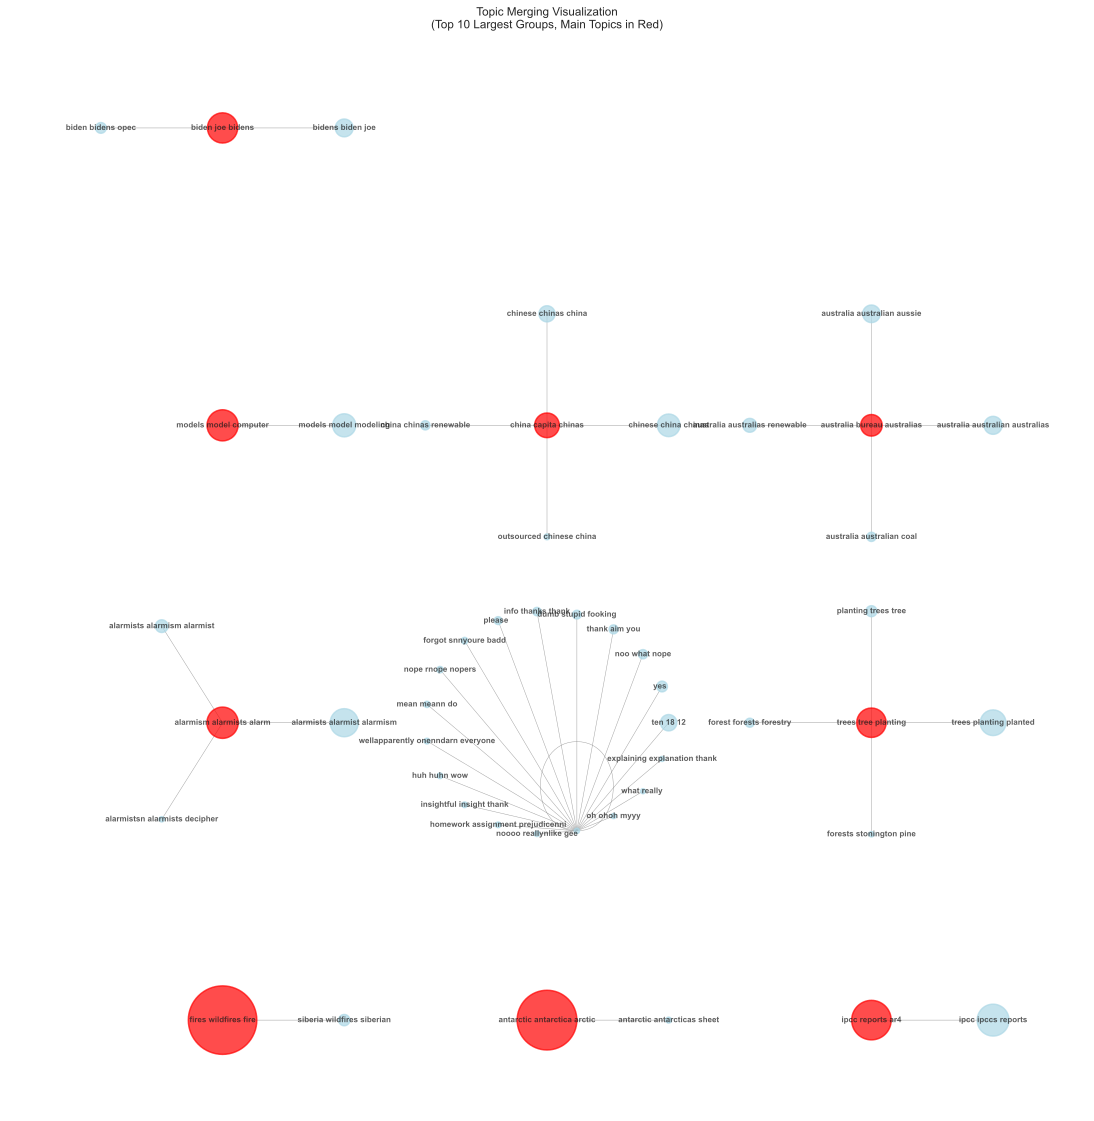


Showing top 10 merged topic groups
Total nodes shown: 49


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import networkx as nx

# Initialize lists for graph data
nodes, edges, node_sizes = [], [], []

# Function to create pretty names
def create_pretty_name(name):
    words = name.split('_')[1:]  # Skip the first element which is a number
    return ' '.join(words[:3])  # Use the first two words

# Get sizes of merged groups and sort by total count
group_sizes = []
for group in merged_groups:
    total_count = sum(freq_filtered.iloc[idx]['Count'] for idx in group)
    group_sizes.append((group, total_count))

# Sort groups by size and take top 10 (fewer groups for clearer visualization)
sorted_groups = sorted(group_sizes, key=lambda x: x[1], reverse=True)[:10]

# Create graph
G = nx.Graph()

# Add nodes and edges for each group
for group, total_count in sorted_groups:
    main_topic_index = group[0]
    
    main_topic_name = create_pretty_name(freq_filtered.iloc[main_topic_index]['Name'])
    main_topic_count = freq_filtered.iloc[main_topic_index]['Count']
    
    # Add main topic node
    G.add_node(main_topic_name, size=main_topic_count, is_main=True)
    
    # Add merged topic nodes and edges
    for topic_index in group[1:]:
        merged_name = create_pretty_name(freq_filtered.iloc[topic_index]['Name'])
        merged_count = freq_filtered.iloc[topic_index]['Count']
        G.add_node(merged_name, size=merged_count, is_main=False)
        G.add_edge(main_topic_name, merged_name, weight=merged_count)

# Set up the plot
plt.figure(figsize=(15, 15))

# Create a circular layout for merged nodes around their main topic
pos = {}
for i, (group, _) in enumerate(sorted_groups):
    main_topic_name = create_pretty_name(freq_filtered.iloc[group[0]]['Name'])
    # Place main topic in a grid layout
    grid_x = (i % 3) - 1  # 3 columns
    grid_y = (i // 3) - 1  # Rows as needed
    pos[main_topic_name] = (grid_x * 4, grid_y * 4)  # Spread out the main topics
    
    # Place merged topics in a circle around the main topic
    merged_nodes = [create_pretty_name(freq_filtered.iloc[idx]['Name']) for idx in group[1:]]
    angle_step = 2 * 3.14159 / len(merged_nodes) if merged_nodes else 0
    radius = 1.5
    
    for j, merged_node in enumerate(merged_nodes):
        angle = j * angle_step
        pos[merged_node] = (
            grid_x * 4 + radius * np.cos(angle),
            grid_y * 4 + radius * np.sin(angle)
        )

# Draw the graph
node_colors = ['red' if G.nodes[node]['is_main'] else 'lightblue' for node in G.nodes()]
node_sizes = [G.nodes[node]['size'] * 0.5 for node in G.nodes()]

nx.draw(G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        with_labels=True,
        font_size=8,
        font_weight='bold',
        edge_color='gray',
        width=0.5,
        alpha=0.7)

plt.title("Topic Merging Visualization\n(Top 10 Largest Groups, Main Topics in Red)")
plt.axis('off')
plt.tight_layout()
plt.show()

# Output summary
print(f"\nShowing top {len(sorted_groups)} merged topic groups")
print(f"Total nodes shown: {len(G.nodes())}")

# Load IEA TRL

In [45]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Load IEA Clean Tech Guide
iea_df = pd.read_csv('paper4data/IEA_Clean_Tech_Guide.csv')
print(f"Shape: {iea_df.shape}")
print(f"Columns: {list(iea_df.columns)}")

# Create search query for heat pumps
query = "heat pumps"
query_embedding = model.encode([query])

# Create text to search against (combine name and description)
iea_texts = [f"{row['name']} {row['description']}" for _, row in tqdm(iea_df.iterrows(), total=len(iea_df), desc="Preparing texts")]

# Encode all IEA technology descriptions
print("Encoding technology descriptions...")
iea_embeddings = model.encode(iea_texts, show_progress_bar=True)

# Calculate similarities and get top matches
similarities = cosine_similarity(query_embedding, iea_embeddings)[0]
top_indices = np.argsort(similarities)[::-1][:10]

print(f"\nTop matches for '{query}':")
print("-" * 50)
for i, idx in enumerate(top_indices):
    similarity_score = similarities[idx]
    print(f"{i+1}. {iea_df.iloc[idx]['name']} (similarity: {similarity_score:.3f})")
    print(f"   Description: {iea_df.iloc[idx]['description'][:100]}...")
    print(f"   Sector: {iea_df.iloc[idx]['sector']}")
    print(f"   TRL 2024: {iea_df.iloc[idx]['trl2024']}")
    print()


Shape: (604, 13)
Columns: ['name', 'sector', 'trl2020', 'trl2021', 'trl2022', 'trl2023', 'trl2024', 'description', 'NZErationale', 'supplyChain', 'theme', 'keyCountries', 'read_more']


Preparing texts:   0%|          | 0/604 [00:00<?, ?it/s]

Preparing texts: 100%|██████████| 604/604 [00:00<00:00, 54902.36it/s]


Encoding technology descriptions...


Batches: 100%|██████████| 19/19 [00:04<00:00,  4.03it/s]


Top matches for 'heat pumps':
--------------------------------------------------
1. Heat pumps with hydrocarbon refrigerant (similarity: 0.720)
   Description: Heat pump transferring heat from the outside air to a water circuit and/or tank, using hydrocarbon s...
   Sector: Demand,Buildings,Heating and cooling,Generation,Heat pumps,Air‐to‐water heat pump,Heat pumps with hydrocarbon refrigerant
   TRL 2024: 6

2. State-of-the-art air-to-air heat pump (similarity: 0.686)
   Description: Transfer heat energy from a colder space to a warmer one, providing either heating or cooling (using...
   Sector: Demand,Buildings,Heating and cooling,Generation,Heat pumps,Air‐to‐air heat pump,State-of-the-art air-to-air heat pump
   TRL 2024: 10

3. Central heat pump water heaters (similarity: 0.683)
   Description: Heat pump transferring heat from the outside air to a domestic hot water tank....
   Sector: Demand,Buildings,Heating and cooling,Generation,Heat pumps,Air‐to‐water heat pump,Central heat 

In [77]:
import re
from collections import defaultdict

# Get only Climate Solution topics from freq_filtered 
climate_solution_topics = freq_filtered[freq_filtered['category']=="Climate Solution"]

# Pre-compute embeddings to save compute time
print("Pre-computing embeddings...")
embeddings_cache = {}

# Pre-compute all topic embeddings (only for climate solution topics)
for _, row in tqdm(climate_solution_topics.iterrows(), total=len(climate_solution_topics), desc="Computing topic embeddings"):
    topic_keywords = row['Name']
    query = topic_keywords.replace('_', ' ')
    if query not in embeddings_cache:
        embeddings_cache[query] = model.encode([query])

# First pass: find which IEA techs match with climate solution topics
print("Finding matching IEA technologies...")
matching_iea_techs = set()

for _, row in tqdm(climate_solution_topics.iterrows(), total=len(climate_solution_topics), desc="Finding IEA matches"):
    topic_keywords = row['Name']
    query = topic_keywords.replace('_', ' ')
    query_embedding = embeddings_cache[query]
    
    # Calculate similarities with all IEA techs
    similarities = cosine_similarity(query_embedding, iea_embeddings)[0]
    
    # Find techs with similarity > 0.4
    high_similarity_indices = [i for i, sim in enumerate(similarities) if sim > 0.4]
    
    # Add matching tech names to our set
    for idx in high_similarity_indices:
        matching_iea_techs.add(iea_df.iloc[idx]['name'])

print(f"Found {len(matching_iea_techs)} matching IEA technologies")

# Fast string matching function using word overlap
def fast_string_match(tech_name, doc_text):
    """Fast string matching using word overlap and keyword presence"""
    tech_words = set(re.findall(r'\b\w+\b', tech_name.lower()))
    doc_words = set(re.findall(r'\b\w+\b', doc_text.lower()))
    
    # Calculate Jaccard similarity (intersection over union)
    if not tech_words or not doc_words:
        return 0.0
    
    intersection = len(tech_words.intersection(doc_words))
    union = len(tech_words.union(doc_words))
    
    jaccard_score = intersection / union if union > 0 else 0.0
    
    # Bonus for exact substring matches
    substring_bonus = 0.0
    tech_lower = tech_name.lower()
    doc_lower = doc_text.lower()
    
    if tech_lower in doc_lower or any(word in doc_lower for word in tech_words if len(word) > 3):
        substring_bonus = 0.2
    
    return min(1.0, jaccard_score + substring_bonus)

# Initialize list to store results
results = []

for _, row in tqdm(climate_solution_topics.iterrows(), total=len(climate_solution_topics), desc="Processing topics"):
    topic_name = row['Name']
    topic_keywords = row['Name']
    merged_topic_id = row['Topic']
    
    # Get original topic names for this merged topic
    original_topics = freq_all[freq_all['Topic'] == merged_topic_id]['Name'].iloc[0] if len(freq_all[freq_all['Topic'] == merged_topic_id]) > 0 else topic_keywords
    
    # Create search query using topic keywords
    query = topic_keywords.replace('_', ' ')
    
    # Use cached embedding
    query_embedding = embeddings_cache[query]
    
    # Calculate similarities and get top matches
    similarities = cosine_similarity(query_embedding, iea_embeddings)[0]
    
    # Filter to only show matches with similarity > 0.4
    high_similarity_indices = [i for i, sim in enumerate(similarities) if sim > 0.4]
    
    if high_similarity_indices:
        # Sort by similarity score in descending order
        high_similarity_indices = sorted(high_similarity_indices, key=lambda x: similarities[x], reverse=True)
        
        for i, idx in enumerate(high_similarity_indices):
            similarity_score = similarities[idx]
            iea_tech_name = iea_df.iloc[idx]['name']
            
            # Get documents for this topic
            topic_documents = df_topics_all[df_topics_all['Topic'] == merged_topic_id]['Document'].tolist()
            
            if topic_documents and len(topic_documents) > 0:
                # Use fast string matching instead of fuzzy matching
                doc_sample = topic_documents  # No limit on sample size
                
                # For each document, calculate fast match score with IEA tech name
                for doc_text in doc_sample:
                    # Calculate fast match score between IEA tech name and document text
                    fast_score = fast_string_match(iea_tech_name, doc_text)
                    
                    truncated_doc = doc_text[:150] + "..." if len(doc_text) > 150 else doc_text
                    
                    # Add result to list - one row per document
                    results.append({
                        'topic_id': merged_topic_id,
                        'topic_name': topic_name,
                        'topic_keywords': topic_keywords,
                        'original_topics': original_topics,
                        'iea_tech_name': iea_tech_name,
                        'iea_tech_description': iea_df.iloc[idx]['description'],
                        'iea_tech_sector': iea_df.iloc[idx]['sector'],
                        'iea_tech_trl2024': iea_df.iloc[idx]['trl2024'],
                        'similarity_score': similarity_score,
                        'doc_similarity': fast_score,
                        'doc_text': truncated_doc,
                        'bert_score': fast_score  # Using fast score as bert_score for consistency
                    })
            else:
                # If no documents, keep one row with null values for doc fields
                results.append({
                    'topic_id': merged_topic_id,
                    'topic_name': topic_name,
                    'topic_keywords': topic_keywords,
                    'original_topics': original_topics,
                    'iea_tech_name': iea_tech_name,
                    'iea_tech_description': iea_df.iloc[idx]['description'],
                    'iea_tech_sector': iea_df.iloc[idx]['sector'],
                    'iea_tech_trl2024': iea_df.iloc[idx]['trl2024'],
                    'similarity_score': similarity_score,
                    'doc_similarity': None,
                    'doc_text': None,
                    'bert_score': None
                })

# Convert results to DataFrame - already expanded with one row per document
climate_iea_matches_expanded_df = pd.DataFrame(results)


Pre-computing embeddings...


Computing topic embeddings: 100%|██████████| 17/17 [00:00<00:00, 111.19it/s]


Finding matching IEA technologies...


Finding IEA matches: 100%|██████████| 17/17 [00:00<00:00, 1544.76it/s]

Found 59 matching IEA technologies



Processing topics: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]


In [82]:
# Print top 3 matches for each IEA tech for manual inspection
print("Top 3 matches for each IEA technology:\n")
print("="*80)

for iea_tech in climate_iea_matches_expanded_df['iea_tech_name'].unique():
    tech_matches = climate_iea_matches_expanded_df[
        climate_iea_matches_expanded_df['iea_tech_name'] == iea_tech
    ].sort_values('bert_score', ascending=False)
    
    print(f"\n{iea_tech}")
    print("-" * len(iea_tech))
    
    top_3 = tech_matches.head(3)
    for i, (idx, row) in enumerate(top_3.iterrows(), 1):
        print(f"\n{i}. BERT Score: {row['bert_score']:.4f}")
        print(f"   Topic: {row['topic_name']}")
        print(f"   Document: {row['doc_text']}")



Top 3 matches for each IEA technology:


Nuclear-powered ship
--------------------

1. BERT Score: 0.7000
   Topic: nuclear reactors reactor uranium climate
   Document: So nuclear powered?

2. BERT Score: 0.5333
   Topic: nuclear reactors reactor uranium climate
   Document: Nuclear. 

3. BERT Score: 0.5333
   Topic: nuclear reactors reactor uranium climate
   Document: Nuclear?

High and very high temperature reactor
--------------------------------------

1. BERT Score: 0.4222
   Topic: nuclear reactors reactor uranium climate
   Document: And for many high energy states

2. BERT Score: 0.3667
   Topic: nuclear reactors reactor uranium climate
   Document: Kairos Power Selects East Tennessee Technology Park Site for Fluoride Salt-Cooled High-Temperature Test Reactor

3. BERT Score: 0.3667
   Topic: nuclear reactors reactor uranium climate
   Document: Breeder reactor. 

Nuclear fusion
--------------

1. BERT Score: 1.0000
   Topic: fusion fission iter tokamak climate
   Document: Nu

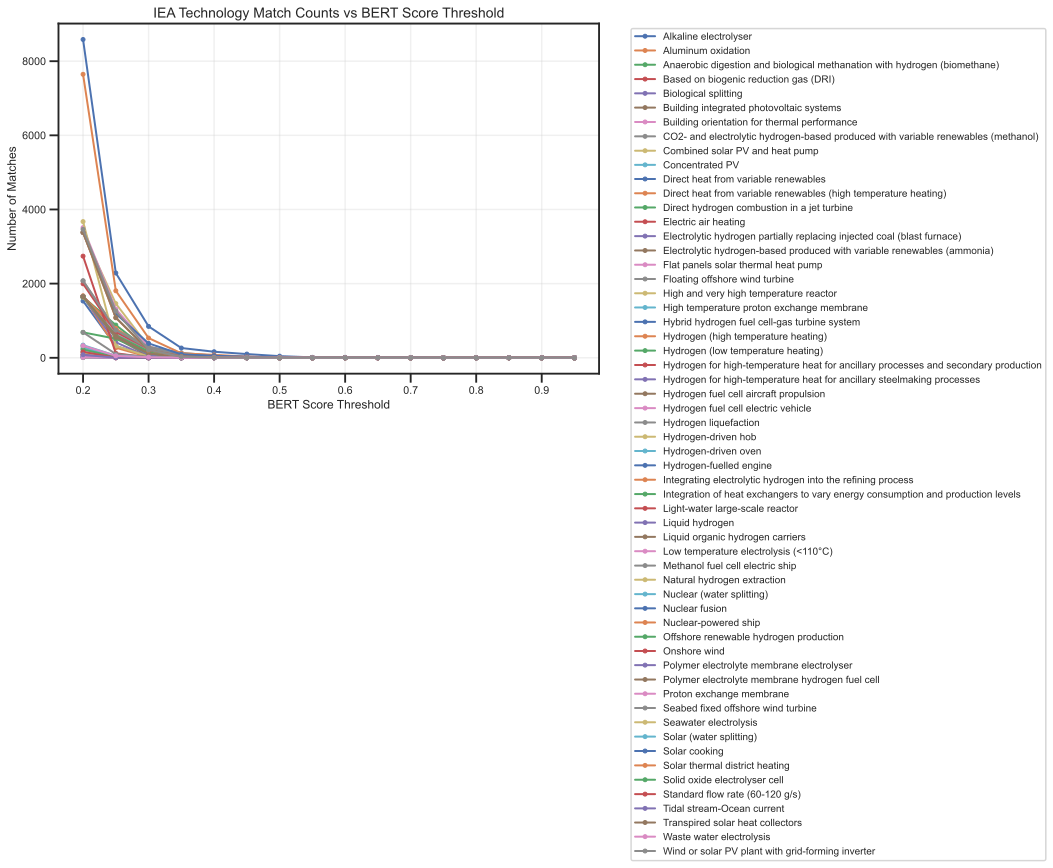


Match counts at key thresholds:

Threshold >= 0.2:
iea_tech_name
Nuclear fusion                                       8585
Nuclear-powered ship                                 7646
High and very high temperature reactor               3673
Flat panels solar thermal heat pump                  3511
Wind or solar PV plant with grid-forming inverter    3464
Combined solar PV and heat pump                      3386
Transpired solar heat collectors                     3384
Solar thermal district heating                       3378
Solar cooking                                        3375
Light-water large-scale reactor                      2741
dtype: int64

Threshold >= 0.3:
iea_tech_name
Nuclear fusion                                       846
Nuclear-powered ship                                 532
Solar cooking                                        388
Combined solar PV and heat pump                      305
Flat panels solar thermal heat pump                  301
Floating offshore wind 

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Define thresholds to test
thresholds = np.arange(0.2, 1.0, 0.05)

# Calculate match counts for each IEA tech at each threshold
iea_tech_counts = {}
for threshold in thresholds:
    # Filter matches above threshold
    filtered_matches = climate_iea_matches_expanded_df[climate_iea_matches_expanded_df['bert_score'] >= threshold]
    
    # Count matches per IEA tech
    tech_counts = filtered_matches.groupby('iea_tech_name').size()
    
    for tech_name in tech_counts.index:
        if tech_name not in iea_tech_counts:
            iea_tech_counts[tech_name] = []
        iea_tech_counts[tech_name].append(tech_counts[tech_name])
    
    # Fill in zeros for techs with no matches at this threshold
    for tech_name in iea_tech_counts:
        if len(iea_tech_counts[tech_name]) < len([t for t in thresholds if t <= threshold]):
            iea_tech_counts[tech_name].append(0)

# Create the plot
plt.figure(figsize=(15, 10))

# Plot each IEA tech
for tech_name, counts in iea_tech_counts.items():
    # Pad counts to match thresholds length if needed
    while len(counts) < len(thresholds):
        counts.append(0)
    plt.plot(thresholds, counts, marker='o', label=tech_name, linewidth=2, markersize=4)

plt.xlabel('BERT Score Threshold', fontsize=12)
plt.ylabel('Number of Matches', fontsize=12)
plt.title('IEA Technology Match Counts vs BERT Score Threshold', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Also show a summary table
print("\nMatch counts at key thresholds:")
summary_thresholds = [0.2, 0.3, 0.4, 0.5]
for threshold in summary_thresholds:
    filtered_matches = climate_iea_matches_expanded_df[climate_iea_matches_expanded_df['bert_score'] >= threshold]
    tech_counts = filtered_matches.groupby('iea_tech_name').size().sort_values(ascending=False)
    print(f"\nThreshold >= {threshold}:")
    print(tech_counts.head(10))

# OpenAI pretty name and description

In [ ]:
# Import packages and define variables
from openai import OpenAI
import os
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

api_key = "sk-proj-4X1CldONLWYUuze7sCoZT3BlbkFJciLeUe9BfYhvNv1NlW4x" #IIASA

# Create 5 OpenAI clients
clients = [OpenAI(api_key=api_key) for _ in range(5)]

batch_size = 10

# Filter freq_merged to first 100 topics, excluding topic 0/-1
freq_filtered = freq_merged[1:101]
topic_batches = [freq_filtered.iloc[i:i+batch_size] for i in range(0, len(freq_filtered), batch_size)]

def prepare_topic_data(row):
    # Defensive: handle missing or short Representative_Docs
    rep_docs = row['Representative_Docs']
    if isinstance(rep_docs, list):
        rep_docs = rep_docs[:3]
    else:
        rep_docs = []
    return {
        "topic_id": int(row.name),
        "name": str(row['Name']),
        "representative_docs": rep_docs
    }

def create_completion(client, messages):
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error in API call: {str(e)}")
        return None

def build_apio_prompt(batch):
    # System message for structured output
    system_msg = {
        "role": "system",
        "content": (
            "You are a helpful assistant. For each topic provided, return a JSON array. "
            "Each element should be an object with keys: 'topic_id', 'pretty_name', 'description', 'category'.\n"
            "Categories must be one of: 'Climate Solution', 'Climate Cause', 'Climate Impact', 'Scientific or Societal Initiative'.\n"
            "Example output:\n"
            "[\n"
            "  {\n"
            "    \"topic_id\": 1,\n"
            "    \"pretty_name\": \"Renewable Energy\",\n"
            "    \"description\": \"Discussion of solar, wind, and other renewable energy sources.\",\n"
            "    \"category\": \"Climate Solution\"\n"
            "  },\n"
            "  ...\n"
            "]"
        )
    }
    # User message with topics
    user_msg = {
        "role": "user",
        "content": (
            "For each topic below, provide:\n"
            "1. A concise, descriptive name (1-3 words)\n"
            "2. A brief description of the topic (1-2 sentences)\n"
            "3. Classify the topic into one of these categories:\n"
            "   - Climate Solution\n"
            "   - Climate Cause\n"
            "   - Climate Impact\n"
            "   - Scientific or Societal Initiative\n\n"
            "Return a JSON array as described above.\n\n"
            "Topics:\n" +
            "\n".join([
                f"{{\n  \"topic_id\": {d['topic_id']},\n  \"name\": \"{d['name']} for climate\",\n  \"representative_docs\": {d['representative_docs']}\n}}"
                for _, row in batch.iterrows()
                for d in [prepare_topic_data(row)]
            ])
        )
    }
    return [system_msg, user_msg]

def process_batch(args):
    batch, client_idx = args
    client = clients[client_idx % len(clients)]
    import json
    max_retries = 3
    retry_count = 0

    while retry_count < max_retries:
        try:
            messages = build_apio_prompt(batch)
            response = create_completion(client, messages)
            if not response:
                raise Exception("Empty response from API")

            # Try to extract JSON from the response robustly
            import re
            match = re.search(r'(\[.*\])', response, re.DOTALL)
            if match:
                json_str = match.group(1)
            else:
                json_str = response

            try:
                topic_results = json.loads(json_str)
            except Exception as e:
                # Try to fix common JSON issues
                json_str_fixed = json_str.replace('\n', '').replace('\r', '')
                topic_results = json.loads(json_str_fixed)

            results = []
            for i, topic in enumerate(topic_results):
                try:
                    idx = topic.get("topic_id", None)
                    name = topic.get("pretty_name", "Error")
                    desc = topic.get("description", "Error processing topic")
                    category = topic.get("category", "Error")
                    valid_categories = ["Climate Solution", "Climate Cause", "Climate Impact", "Scientific or Societal Initiative"]
                    if category not in valid_categories:
                        raise Exception(f"Invalid category: {category}")
                    if idx is None:
                        idx = batch.index[i]
                    results.append((idx, name, desc, category))
                except Exception as e:
                    print(f"Error processing topic {i}: {str(e)}")
                    results.append((batch.index[i], "Error", "Error processing topic", "Error"))

            # If not enough results, fill the rest with error
            while len(results) < len(batch):
                idx = batch.index[len(results)]
                results.append((idx, "Error", "Error processing topic", "Error"))

            return results

        except Exception as e:
            print(f"Error processing batch (attempt {retry_count + 1}): {str(e)}")
            retry_count += 1
            time.sleep(2)

    # If all retries fail, fill with error
    results = []
    for i, idx in enumerate(batch.index):
        results.append((idx, "Error", "Error processing topic", "Error"))
    return results

# Process batches with error checking and parallel execution
pretty_names = [""] * len(freq_merged)
descriptions = [""] * len(freq_merged)
categories = [""] * len(freq_merged)

# Create batch arguments with client indices
batch_args = [(batch, i) for i, batch in enumerate(topic_batches)]

with ThreadPoolExecutor(max_workers=5) as executor:
    results = list(tqdm(executor.map(process_batch, batch_args), total=len(batch_args)))

for batch_results in results:
    if batch_results is None:
        print("Error processing batch")
        continue
    for idx, name, desc, category in batch_results:
        pretty_names[idx] = name
        descriptions[idx] = desc
        categories[idx] = category

# Map results back to freq_filtered using proper indexing
for batch_results in results:
    if batch_results is None:
        print("Error processing batch")
        continue
    for idx, name, desc, category in batch_results:
        # Ensure we're mapping to the correct row in freq_filtered
        freq_filtered.loc[idx, 'pretty_name'] = name
        freq_filtered.loc[idx, 'description'] = desc
        freq_filtered.loc[idx, 'category'] = category


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


In [56]:

# Map results back to freq_filtered using proper indexing
for batch_results in results:
    if batch_results is None:
        print("Error processing batch")
        continue
    for idx, name, desc, category in batch_results:
        # Ensure we're mapping to the correct row in freq_filtered
        freq_filtered.loc[idx, 'pretty_name'] = name
        freq_filtered.loc[idx, 'description'] = desc
        freq_filtered.loc[idx, 'category'] = category


C:\Users\chowdhary\AppData\Local\Temp\ipykernel_38900\1052326906.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\chowdhary\AppData\Local\Temp\ipykernel_38900\1052326906.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\chowdhary\AppData\Local\Temp\ipykernel_38900\1052326906.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [57]:
print(freq_filtered[freq_filtered['category']=="Climate Solution"][['pretty_name', 'category', 'Topic', 'Count', 'Name']].shape)
freq_filtered[freq_filtered['category']=="Climate Solution"][['pretty_name','description' ,'category', 'Topic', 'Count', 'Name']]

(17, 5)


,pretty_name,description,category,Topic,Count,Name
2,Nuclear Energy,Discussion of nuclear reactors and their role ...,Climate Solution,1,9290,nuclear reactors reactor uranium climate
7,Solar Panels,Conversations about the use and implementation...,Climate Solution,6,3676,panels solar pv rooftop climate
8,Veganism,Exploration of veganism and vegetarianism as d...,Climate Solution,7,3582,vegan veganism vegans vegetarian climate
16,Offshore Wind Turbines,Discussion on the development and impact of of...,Climate Solution,15,2104,turbines turbine offshore windmills climate
28,Germany's Energy Policy,Germany's approach to renewable energy and its...,Climate Solution,27,1781,germany germanys german germans climate
...,...,...,...,...,...,...
74,Nuclear Fusion,"Exploration of nuclear fusion technology, incl...",Climate Solution,73,1017,fusion fission iter tokamak climate
78,Carbon Tax,Debate surrounding carbon taxes as a mechanism...,Climate Solution,77,936,tax taxes carbon revenue climate
84,Carbon Footprint Calculator,Tools and discussions about measuring individu...,Climate Solution,83,833,footprint footprints app calculator climate
87,Carbon Offsets,Discussions on the effectiveness and ethical c...,Climate Solution,86,808,offsets offsetting offset carbon climate


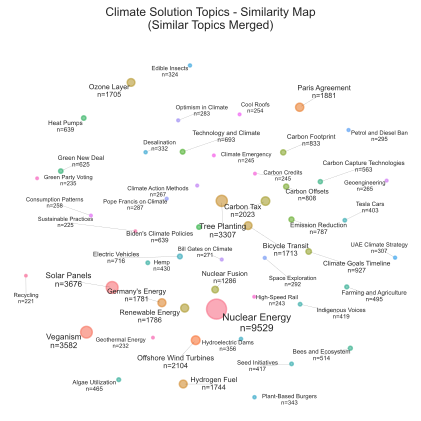

In [81]:
# Import required libraries
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Get climate solution topics
climate_solutions = freq_all[freq_all['category']=="Climate Solution"][['pretty_name','description', 'category', 'Topic', 'Count', 'Name']]

# Prepare texts and labels
texts = []
labels = []
counts = []
for _, row in climate_solutions.iterrows():
    text = f"{row['pretty_name']} {row['description']}"
    texts.append(text)
    labels.append(row['pretty_name'])
    counts.append(row['Count'])

# Create TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english')
embeddings = vectorizer.fit_transform(texts).toarray()

# Calculate pairwise cosine similarities
similarities = 1 - squareform(pdist(embeddings, metric='cosine'))

# Find and merge similar topics (similarity > 0.35)
merged_labels = labels.copy()
merged_counts = counts.copy()
merged_embeddings = embeddings.copy()

i = 0
while i < len(merged_labels):
    j = i + 1
    while j < len(merged_labels):
        if similarities[i,j] >= 0.35:
            # Keep name of topic with higher count
            if merged_counts[i] >= merged_counts[j]:
                merged_labels[i] = merged_labels[i]
            else:
                merged_labels[i] = merged_labels[j]
            merged_counts[i] = merged_counts[i] + merged_counts[j]
            merged_embeddings[i] = (merged_embeddings[i] + merged_embeddings[j]) / 2
            
            # Remove merged topic
            del merged_labels[j]
            del merged_counts[j]
            merged_embeddings = np.delete(merged_embeddings, j, axis=0)
            similarities = np.delete(np.delete(similarities, j, axis=0), j, axis=1)
            j -= 1
        j += 1
    i += 1

# Reduce dimensionality using t-SNE with higher perplexity for better separation
perplexity = min(30, max(5, len(merged_labels) // 5))
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
embeddings_2d = tsne.fit_transform(merged_embeddings)

# Set up the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Calculate marker sizes based on counts
merged_counts = np.array(merged_counts)
marker_sizes = 400 * (merged_counts/merged_counts.max())**1.1  # Square root scaling

# Create color palette using seaborn
colors = sns.color_palette("husl", n_colors=len(merged_labels))

# Create scatter plot
scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                    s=marker_sizes,
                    c=colors,
                    alpha=0.6)

# Adjust label positions to minimize overlap
from adjustText import adjust_text

texts = []
for i, label in enumerate(merged_labels):
    # Scale font size based on square root of count
    font_size = 5 + 5 * np.sqrt(merged_counts[i]/merged_counts.max())  # Base size 5, max additional 5
    
    # Add topic name and count on separate lines
    label_with_count = f"{label}\nn={merged_counts[i]}"
    
    # Create text object with different font sizes for label and count
    text = ax.text(embeddings_2d[i, 0], embeddings_2d[i, 1], 
                  label_with_count,
                  fontsize=font_size,
                  va='center',
                  ha='center',
                  linespacing=1.2,  # Increase space between lines
                  bbox=dict(facecolor='white', 
                          edgecolor='none',
                          alpha=0.01,
                          pad=2))
    
    # Only try to adjust font size if text has multiple parts
    if len(text.get_children()) > 1:
        text.get_children()[1].set_fontsize(font_size * 0.7)
    texts.append(text)

# Adjust text positions to minimize overlap and add arrows
adjust_text(texts, 
           embeddings_2d[:, 0], embeddings_2d[:, 1],
           expand_points=(2, 2),
           force_points=0.5,
           ha='center', # Allow text on all sides
           arrowprops=dict(arrowstyle='-', color='k', alpha=0.5, linewidth=0.2))


ax.set_title('Climate Solution Topics - Similarity Map\n(Similar Topics Merged)', 
            fontsize=12, 
            pad=20)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Add subtle grid
ax.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
plt.savefig('paper 4 figs/paper4_solutions_map.pdf', dpi=300, bbox_inches='tight')
plt.savefig('paper 4 figs/paper4_solutions_map.png', dpi=300, bbox_inches='tight')




In [ ]:
# !pip install spacy
# merged_df[['Document','nouns']]

In [ ]:
# !pip install spacy
# merged_df[['Document','nouns']]

In [4]:
# Define keyword categories for injunctive norms
moral_obligation_keywords = [
    'must', 'should', 'have to', 'need to', 'ought to', 'required to',
    'duty', 'obligation', 'responsibility', 'imperative', 'essential',
    'mandatory', 'compulsory', 'expected to', 'moral duty',
    'right thing to do', 'ethical choice'
]

guilt_shame_keywords = [
    'shameful', 'selfish', 'irresponsible', 'immoral', 'wrong',
    'guilty', 'guilt-tripping', 'hypocritical', 'harmful',
    'complicit', 'you are the problem', 'people like you',
    'how dare you', "can't believe you'd", 'you should feel bad',
    'think of the children', 'future generations will suffer'
]

# Function to find matching keywords in a comment
def find_matching_keywords(comment):
    matches = []
    
    # Convert comment to lowercase for case-insensitive matching
    comment_lower = str(comment).lower()
    
    # Check for moral obligation keywords
    for keyword in moral_obligation_keywords:
        if keyword in comment_lower:
            matches.append(keyword)
            
    # Check for guilt/shame keywords
    for keyword in guilt_shame_keywords:
        if keyword in comment_lower:
            matches.append(keyword)
            
    # Return list of matches if multiple found, single match if one found, or None if none found
    if len(matches) > 1:
        return matches
    elif len(matches) == 1:
        return matches[0]
    else:
        return None

# Apply keyword detection to each comment
norm_keywords = [find_matching_keywords(comment) for comment in comments]

# Count occurrences of each keyword and track co-occurrences
keyword_counts = {}
keyword_pairs = {}
comments_with_norms = set()  # Track unique comments with norms

for i, matches in enumerate(norm_keywords):
    if matches:
        comments_with_norms.add(i)  # Add comment index to set
        if isinstance(matches, list):
            # Count individual keywords
            for keyword in matches:
                keyword_counts[keyword] = keyword_counts.get(keyword, 0) + 1
            
            # Count keyword pairs if multiple keywords present
            if len(matches) > 1:
                for i in range(len(matches)):
                    for j in range(i+1, len(matches)):
                        pair = tuple(sorted([matches[i], matches[j]]))
                        keyword_pairs[pair] = keyword_pairs.get(pair, 0) + 1
        else:
            keyword_counts[matches] = keyword_counts.get(matches, 0) + 1

# Print summary statistics
total_comments_with_norms = len(comments_with_norms)  # Count unique comments with norms
total_comments = len(norm_keywords)

print(f"Total comments analyzed: {total_comments}")
print(f"Comments containing norm keywords: {total_comments_with_norms} ({(total_comments_with_norms/total_comments)*100:.1f}%)")

Total comments analyzed: 9188
Comments containing norm keywords: 2072 (22.6%)
